## Do the abc in R cuz python abc packages suck
https://www.datacamp.com/community/blog/jupyter-notebook-r#gs.CkjgxoE

__NB:__ `conda install -c r rpy2=2.8.6 -f`
rpy2 needs to be a specific version to work in the ipython notebook.

In [67]:
%matplotlib inline
%load_ext rpy2.ipython

GIMME_DIR = "/home/isaac/gimmeSAD/"
os.chdir(GIMME_DIR)

import os
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipyparallel as ipp
import itertools
import random
import glob
import scipy
import rpy2.interactive as r
import rpy2.interactive.packages
import datetime
import time

from ipyrad.assemble.util import progressbar 
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import linregress

GIMME_DIR = "/home/isaac/gimmeSAD/"
os.chdir(GIMME_DIR)
ONED_DIR = GIMME_DIR + "1d_sims/"
TWOD_DIR = GIMME_DIR + "2d_sims/"

## Set up the link to ipcluster and create a loadbalanced view
## Need to run this externally, and wait for a little bit.
## `ipcluster start -n 40 --profile gimmeCV
ipyclient = ipp.Client(profile="gimmeCV")
print(len(ipyclient), 'cores')
thview = ipyclient.load_balanced_view()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
(40, 'cores')


In [3]:
## A function to return RMSE and R
def get_stats(tr, est):
    tr = np.array(tr).flatten()

    rms = sqrt(mean_squared_error(tr, est))
    r = np.corrcoef(np.vstack((tr, est)))[1,0]

    return rms, r

In [86]:
def call_abc(REF_TABLE, model, param, model_args):
    import pandas as pd
    import rpy2.interactive as r
    import rpy2.interactive.packages
    from rpy2 import robjects
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()

    NCV = 10

    r.packages.importr("abc")
    abc = r.packages.packages.abc

    ## Read in the prior
    ## Return the prior as a huge df
    PRIOR = pd.read_csv(REF_TABLE, sep="\t")

    cvresults = abc.cv4abc(PRIOR[param], PRIOR[model_args[model]], nval=NCV, tols=robjects.r["c"](0.01, 0.05), method="loclinear")
    ## results_dict[model][param] = cvresults
    return cvresults


## Gather all the simulations into one huge simout file

In [69]:
def gather_simouts(SIMOUT_DIR, oneper=True):
    REF_TABLE = os.path.join(SIMOUT_DIR, "priors.txt")
    outfile = open(REF_TABLE, "w")

    ONEPER = oneper
    REGULARIZE = False
    DROPEQUILIBSIMS = True

    files = glob.glob(SIMOUT_DIR + "*/sumstats.txt")
    numsims = 0
    outfile.write(open(files[0]).readlines()[0])
    for f in files:
        lines = open(f).readlines()[1:]
        new_lines = []
        for line in lines:
            try:
                ## DO or don't regularlize the histograms
                if REGULARIZE:
                    hist = np.array([int(x) for x in line.split()[7:]])
                    if np.sum(hist):
                        tot = np.sum(hist)
                        hist = hist/float(tot)
                    tmp = line.split()[:7] + map(str,hist)
                    line = " ".join(tmp) + "\n"
                    new_lines.append(line)

                ## Do or don't drop all the extra sims at equilibrium
                if line.split()[3] == "1" and DROPEQUILIBSIMS:
                    pass
                else:
                    new_lines.append(line)
            except:
                pass
        lines = new_lines
        ## Only choose one step per simulation?
        if lines and ONEPER:
            lines = [random.choice(lines)]
        ## Don't write blanks
        if lines:
            numsims += len(lines)
            outfile.write("".join(lines))
            outfile.write("\n")
    outfile.close()
    print("Processed {} simulations.".format(numsims))
    return REF_TABLE

ONED_PRIOR = gather_simouts(ONED_DIR)
TWOD_PRIOR = gather_simouts(TWOD_DIR, oneper=False)


Processed 14640 simulations.
Processed 130030 simulations.


## Walk through and perform CV for each parameter using each data configuration.
## Parallelized with ipcluster so it's much faster

In [85]:
## For the impatient, do them all at once forking w/ ipcluster

models = ["Ma", "Mi", "Mai", "Mmi", "Mami"]
model_args = {"Ma":["shannon"],\
              "Mi":["bin_"+str(x) for x in range(0,10)],\
              "Mai":["shannon"] + ["bin_"+str(x) for x in range(0,10)],\
              "Mmi":["bin_{}_{}".format(x, y) for x in range(0,10) for y in range(0,10)],\
              "Mami":["shannon"] + ["bin_{}_{}".format(x, y) for x in range(0,10) for y in range(0,10)]}
params = ["K", "c", "%equil", "colrate", "extrate", "shannon"]

## Create the dict for holding results
cv_jobs = {}
alljobs = []
for model in models:
    
    ## Select the right prior for each model
    if "m" in model:
        PRIOR = TWOD_PRIOR
    else:
        PRIOR = ONED_PRIOR

    cv_jobs[model] = {}
    for param in params:
        if "a" in model and param == "shannon":
            print("Skipping H' estimation for model - {}".format(model))
            continue
        ## print("Doing {} {}".format(model, param))
        cv_jobs[model][param] = thview.apply(call_abc, *[PRIOR, model, param, model_args])
        alljobs.append(cv_jobs[model][param])

## Wait for all jobs to finish
start = time.time()
while 1:
    total = len(alljobs)
    ready = [i.ready() for i in alljobs]
    printstr = ' waiting   | {} |'
    elapsed = datetime.timedelta(seconds=int(time.time()-start))
    progressbar(total, sum(ready), printstr.format(elapsed))
    time.sleep(0.1)
    if all(ready):
        break

## get results for each model/param combination
results_dict = {}
for model in models:
    results_dict[model] = {}
    for param in params:
        try:
            results_dict[model][param] = cv_jobs[model][param].result()
            print(type(results_dict[model][param]))
        except Exception as inst:
            print("{} {} {}".format(model, param, inst))

Skipping H' estimation for model - Ma
Skipping H' estimation for model - Mai
Skipping H' estimation for model - Mami
  [####################] 100%  waiting   | 0:00:02 | Ma K NameError(global name 'NCV' is not defined)
Ma c NameError(global name 'NCV' is not defined)
Ma %equil NameError(global name 'NCV' is not defined)
Ma colrate NameError(global name 'NCV' is not defined)
Ma extrate NameError(global name 'NCV' is not defined)
Ma shannon 'shannon'
Mi K NameError(global name 'NCV' is not defined)
Mi c NameError(global name 'NCV' is not defined)
Mi %equil NameError(global name 'NCV' is not defined)
Mi colrate NameError(global name 'NCV' is not defined)
Mi extrate NameError(global name 'NCV' is not defined)
Mi shannon NameError(global name 'NCV' is not defined)
Mai K NameError(global name 'NCV' is not defined)
Mai c NameError(global name 'NCV' is not defined)
Mai %equil NameError(global name 'NCV' is not defined)
Mai colrate NameError(global name 'NCV' is not defined)
Mai extrate NameErr

## Do a bunch of nasty rpy2 stuff to get the data out

In [82]:

cv_dict = {}
for model in models:
    cv_dict[model] = {}
    for param in params:
        if "a" in model and param == "shannon":
            print("Skipping H' estimation for model - {}".format(model))
            continue
        cv_dict[model][param] = {}
        cvresults = results_dict[model][param]
        df_true = cvresults[,'true']
        df_est = pandas2ri.ri2py(cvresults[cvresults.names.index('estim')])
        tru = np.array(df_true).flatten()
        est = np.array(df_est).flatten()
        cv_dict[model][param]["true"] = tru
        cv_dict[model][param]["estim"] = est
        rms, r = get_stats(tru, est)
        cv_dict[model][param]["rms"] = rms
        cv_dict[model][param]["r"] = r


SyntaxError: invalid syntax (<ipython-input-82-f9fd787fc6d4>, line 11)

In [83]:
cvresults

K         c     step    %equil   colrate   extrate   shannon  bin_0  \
0      4606  0.027761   900000  0.997829  0.027779  0.005433  3.733896     71   
1      4221  0.020255    20000  0.090263  0.019700  0.007150  2.042067     54   
2      8975  0.002808   990000  0.239666  0.002866  0.001582  3.116721     36   
3      9837  0.039712  1400000  0.989529  0.039449  0.003310  3.957805    124   
4      9862  0.021829  2500000  0.997161  0.021724  0.002655  4.083265     88   
5      4039  0.034781    10000  0.080713  0.035400  0.009700  1.954847     51   
6      5138  0.004872    40000  0.037758  0.005175  0.002775  2.227903     23   
7      5062  0.025095   400000  0.847294  0.024972  0.005210  3.641157     85   
8      8723  0.028355   600000  0.872521  0.028170  0.003553  4.054341     93   
9      9034  0.007084   290000  0.232566  0.007210  0.002438  3.261001     56   
10     5062  0.023658   200000  0.603714  0.023745  0.005700  3.417045     80   
11     2815  0.028328    10000  0.078153  0.026700  0.008900  1.672974     48   
12     4823  0.012444   120000  0.221854  0.012517  0.004958  2.816236     47   
13     8659  0.023484  2800000  0.999885  0.023596  0.002925  4.006077     84   
14     2839  0.027866   200000  0.879183  0.027925  0.008565  3.408849     57   
15     5761  0.027913    40000  0.144246  0.027450  0.006425  2.479324     73   
16     7715  0.010993  1900000  0.915360  0.011066  0.002651  3.936092     62   
17     1920  0.024205   300000  0.988542  0.024607  0.010333  3.198776     50   
18     9936  0.001029  2320000  0.210145  0.000975  0.000727  3.000600     10   
19     8603  0.040373   900000  0.972219  0.040207  0.003620  3.937637    107   
20     4907  0.035689   700000  0.994090  0.035996  0.005757  3.723333    110   
21     8175  0.035524  2000000  0.998532  0.035613  0.003680  3.834470    125   
22     9751  0.005026   480000  0.195877  0.005169  0.002087  3.224068     30   
23     3960  0.032023    20000  0.142677  0.034300  0.009450  2.240222     76   
24     8213  0.002001   380000  0.109582  0.002126  0.001268  2.927849     18   
25     2613  0.013630   500000  0.939150  0.013580  0.006186  3.325143     41   
26     5138  0.005026   170000  0.128260  0.004912  0.002853  2.841364     29   
27     9164  0.032116  1700000  0.998254  0.032244  0.003159  3.997498    113   
28     2285  0.041518    10000  0.172429  0.041000  0.015500  2.120069     52   
29     7586  0.032388    70000  0.234643  0.032500  0.005343  2.890324     93   
...     ...       ...      ...       ...       ...       ...       ...    ...   
14610  8576  0.041518    10000  0.052589  0.043500  0.005000  1.927274     77   
14611  4726  0.032181   800000  0.995345  0.032099  0.005605  3.620728     99   
14612  1920  0.040279   100000  0.824479  0.041520  0.013590  3.120285     59   
14613  4726  0.012201   500000  0.636056  0.012058  0.004576  3.522800     54   
14614  3126  0.042401    10000  0.111004  0.041900  0.011000  2.007783     56   
14615  3681  0.026257    20000  0.123879  0.026600  0.008250  2.251586     55   
14616  9562  0.038942    10000  0.045283  0.040900  0.004400  1.856421     63   
14617  1855  0.022727   200000  0.838275  0.023125  0.009890  3.246933     46   
14618  2877  0.031052    20000  0.205075  0.031200  0.010850  2.427909     69   
14619  8531  0.048490   900000  0.995546  0.048481  0.003976  3.922199    138   
14620  1672  0.024923   200000  0.947368  0.024750  0.011180  3.122384     45   
14621  3187  0.011631   600000  0.871980  0.011710  0.005223  3.371383     53   
14622  9751  0.030538   900000  0.942980  0.030608  0.003064  4.045601     95   
14623  1805  0.013630    30000  0.238781  0.014000  0.008233  2.331474     22   
14624  3060  0.019143   500000  0.915686  0.018924  0.006374  3.550632     43   
14625  2839  0.023658    20000  0.133498  0.023250  0.008750  2.258736     40   
14626  2851  0.020015    10000  0.071554  0.016800  0.005500  2.068930     34   
14627  2919  0.029421   100000  0.661871 

In [10]:
## Print the rms and r2 for each model x param

print("Model\tParam\tRMS\t\tR")
for model in models:
    for param in params:
        try:
            rms = cv_dict[model][param]["rms"]
            r2 = cv_dict[model][param]["r"]**2
            rms = format(rms, ".3f")
            r2 = format(r2, ".3f")
            print("{}\t{}\t{}\t{}".format(model, param, rms, r2))
        except:
            pass
    print("")

Model	Param	RMS		R
Ma	K	2738.656	0.091
Ma	c	0.012	0.432
Ma	%equil	0.207	0.767
Ma	colrate	0.016	0.001
Ma	extrate	0.003	0.314

Mi	K	1342.386	0.764
Mi	c	0.014	0.012
Mi	%equil	0.204	0.708
Mi	colrate	0.007	0.737
Mi	extrate	0.003	0.267
Mi	shannon	0.322	0.688

Mai	K	1151.489	0.886
Mai	c	0.009	0.360
Mai	%equil	0.156	0.833
Mai	colrate	0.009	0.779
Mai	extrate	0.002	0.552

Mmi	K	1258.636	0.722
Mmi	c	0.003	0.981
Mmi	%equil	0.319	0.265
Mmi	colrate	0.006	0.874
Mmi	extrate	0.001	0.787
Mmi	shannon	0.428	0.538

Mami	K	1769.763	0.357
Mami	c	0.007	0.721
Mami	%equil	0.208	0.636
Mami	colrate	0.004	0.809
Mami	extrate	0.001	0.366



## Define function to make the fancy plot

In [29]:
def plot_cv(model, cv_dict):
    f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=1000)
    axarr = [a for b in axarr for a in b]
    
    for param, ax in zip(params, axarr):
        if "a" in model and param == "shannon":
            continue
        print(model, param),

        x = cv_dict[model][param]["true"]
        y = cv_dict[model][param]["estim"]
        
        xmin = ymin = min(x)
        xlim = ylim = max(x)

        RUN_NAME = param
        
        ## linregress gets the rvalue and polyfit/poly1d gives us the fit function so we can draw the regression line
        res = linregress(x,y)
        fit = np.polyfit(x, y, 1)
        fit_fn = np.poly1d(fit)

        ## Calculate RMSE
        err=scipy.sqrt(sum((x-y)**2)/float(len(x)))
        RMSE = "RMSE {0:.4f}".format(cv_dict[model][param]["rms"])
        R2 = "R^2  {0:.4f}".format(cv_dict[model][param]["r"]**2)
        print(RMSE, R2)

        ## Plot the data and the regression line
        ax.scatter(x, y, marker=".", color='w', edgecolors='black')
        pts = np.linspace(xmin, xlim)
        ax.plot(pts, fit_fn(pts), '-r')

        ## Set titles and x/y limits
        ax.set_xlabel("True {}".format(param), fontsize=10)
        ax.set_ylabel("Estimated {}".format(param), fontsize=10)
        ax.set_title(RUN_NAME, fontsize=10)
        #ax.set_xlim(xmin, xlim)
        #ax.set_ylim(ymin, ylim)

        ## Plot the identity line
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

        ## Add RMSE and R^2 to plots
        ax.text(0.2, 0.9, RMSE, ha='center', va='center', transform=ax.transAxes, color='r', size=8)
        ax.text(0.2, 0.78, R2, ha='center', va='center', transform=ax.transAxes, color='r', size=8)

        ## Remove the stupid tick spines
        ax.tick_params(axis=u'both', which=u'both',length=0)

    ## Give a little space between plots
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    plt.suptitle(model, fontsize=13)


('Ma', 'K') ('RMSE 2738.6561', 'R^2  0.0911')
((715.59909516129051, 9964.4009048387088), (2624.4970124703577, 8929.700242171948))
('Ma', 'c') ('RMSE 0.0121', 'R^2  0.4316')
((0.0016455133078604133, 0.051040919524690066), (0.019818664233915394, 0.034572245783245283))
('Ma', '%equil') ('RMSE 0.2073', 'R^2  0.7670')
((0.021780830789162486, 1.0459343506616374), (0.00051858929428585249, 1.0212765802708446))
('Ma', 'colrate') ('RMSE 0.0158', 'R^2  0.0006')
((-0.0022721457962923742, 0.051988996189992483), (0.021850869951017617, 0.035012011642158419))
('Ma', 'extrate') ('RMSE 0.0034', 'R^2  0.3136')
((-0.00077162410790752043, 0.012527066585783597), (0.0031891928320220975, 0.011055671713249976))
('Mi', 'K') ('RMSE 1342.3855', 'R^2  0.7643')
((2989.8990951612905, 10296.10090483871), (2435.2670111278826, 9556.2375389933513))
('Mi', 'c') ('RMSE 0.0137', 'R^2  0.0120')
((0.0097997935906978806, 0.044522318895002633), (0.012961637275828008, 0.040707196649758623))
('Mi', '%equil') ('RMSE 0.2042', 'R^2

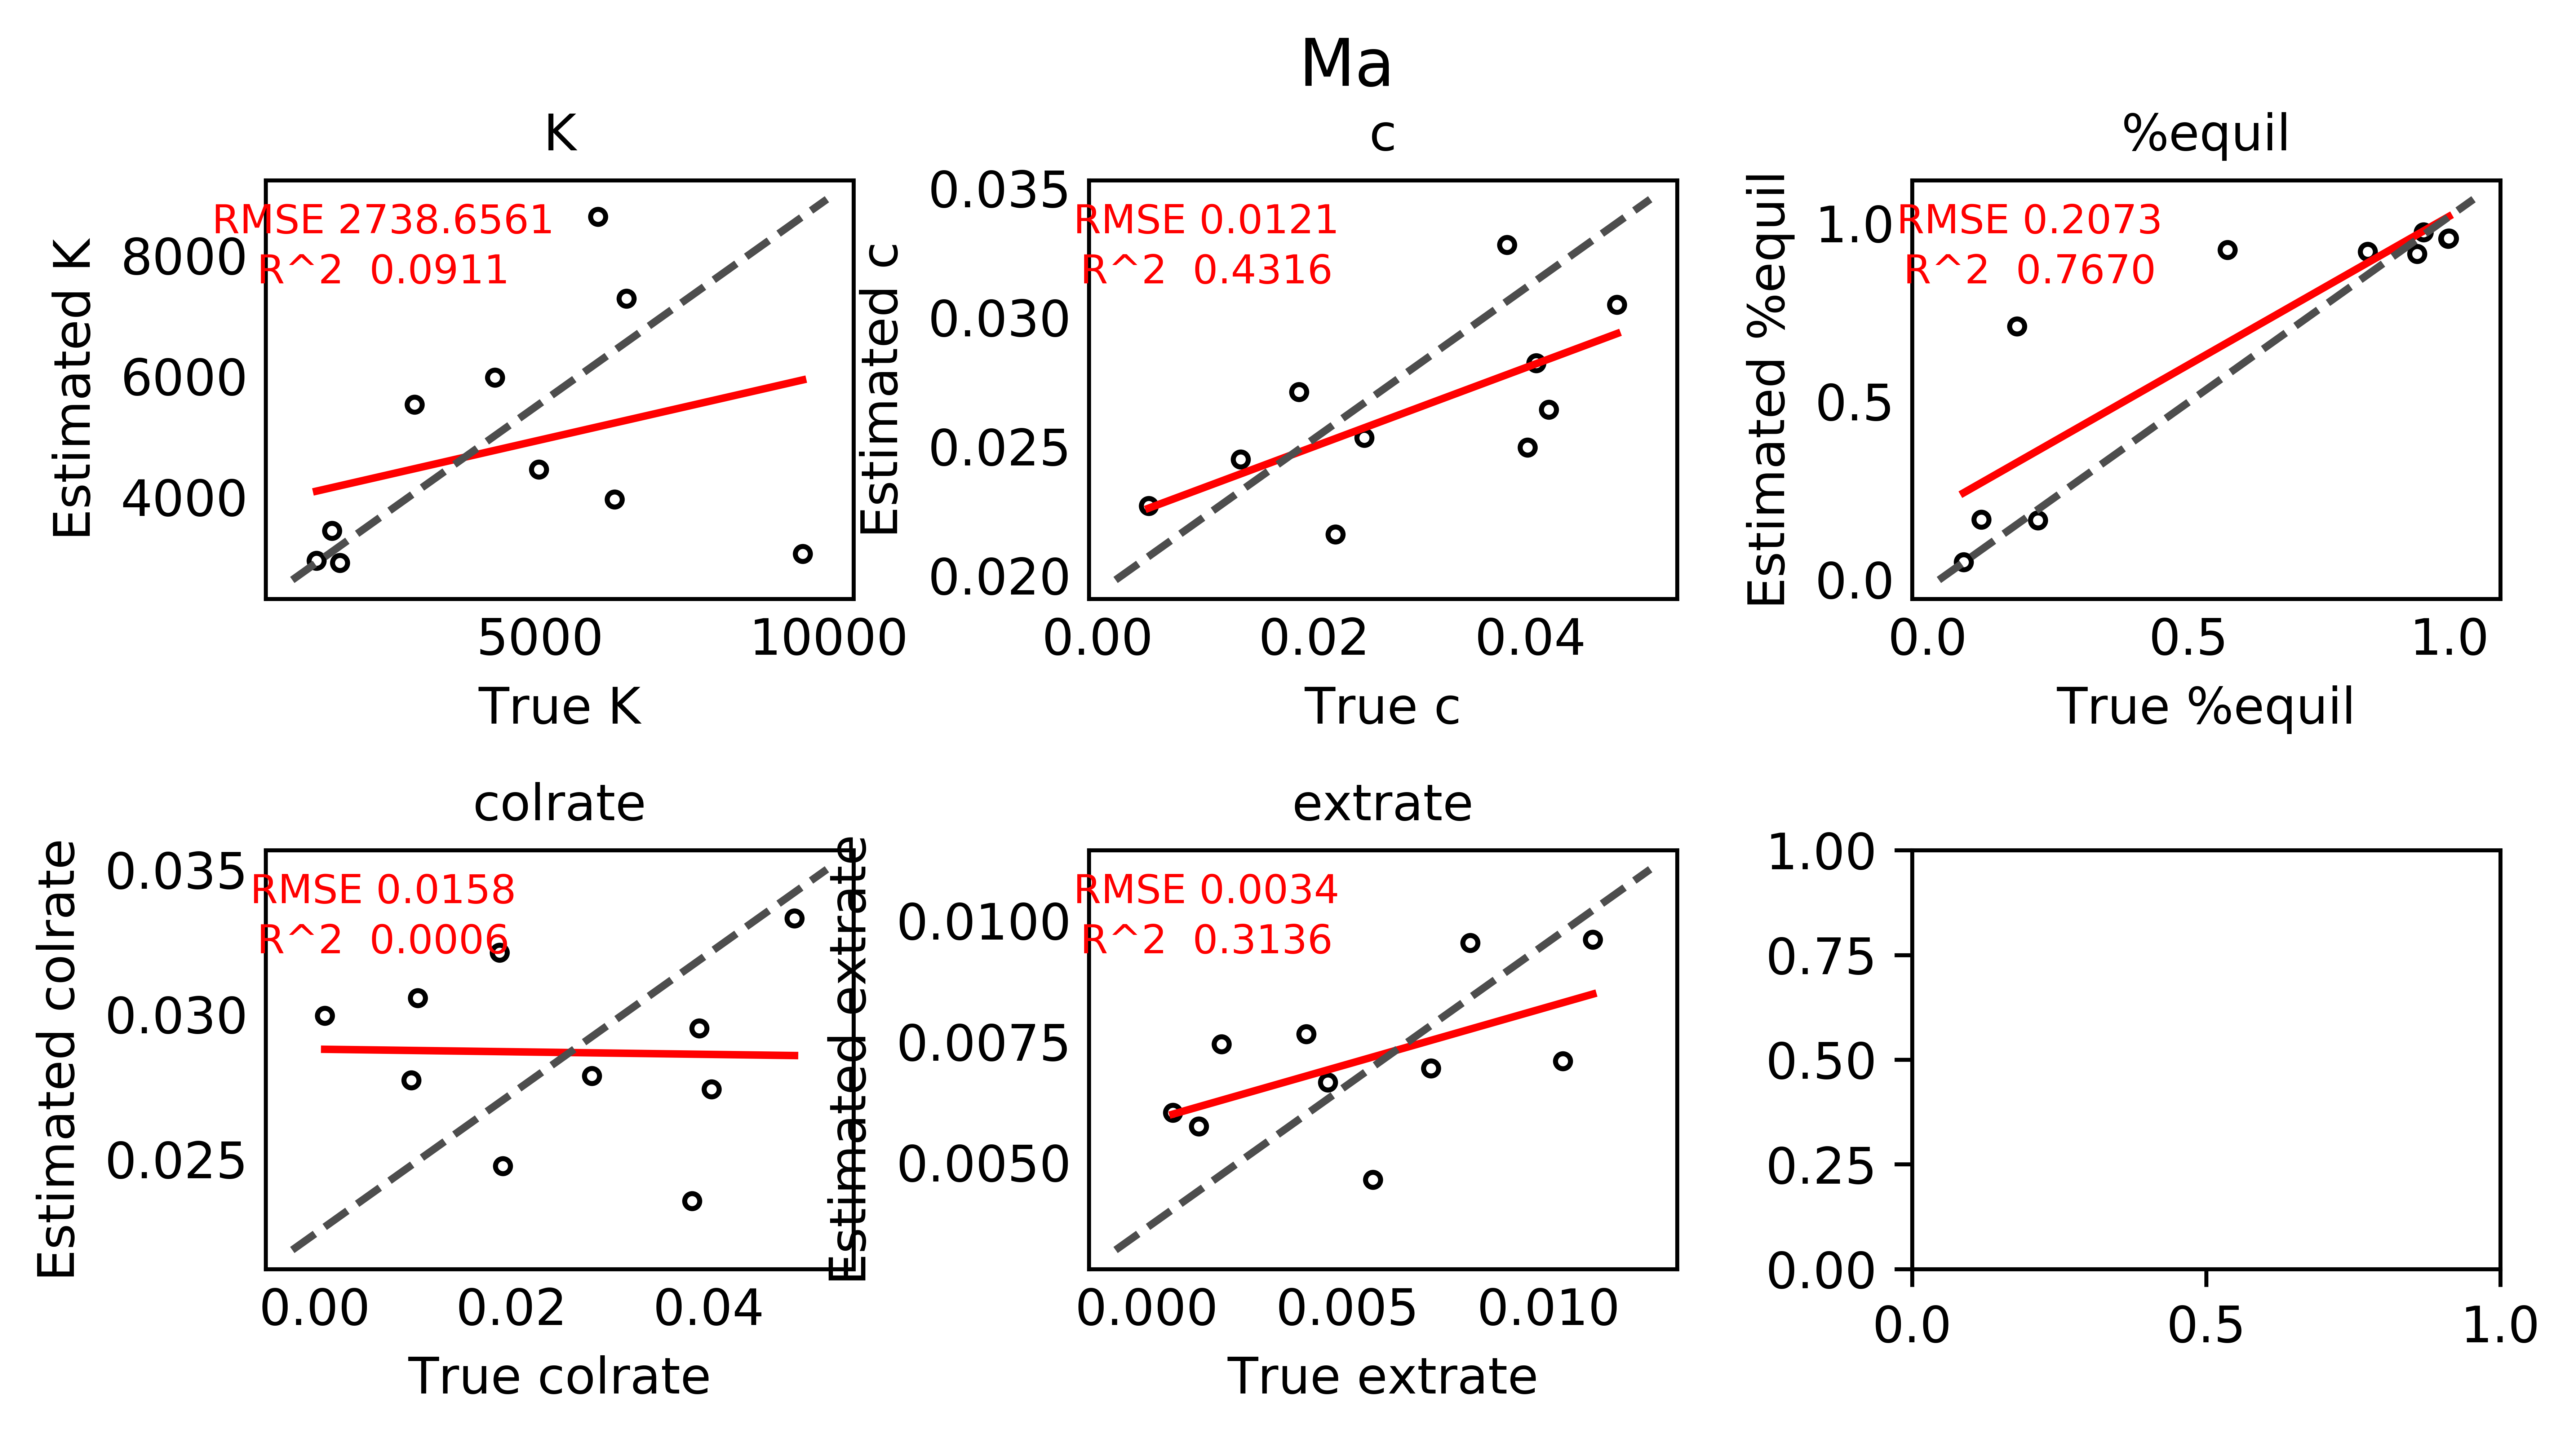

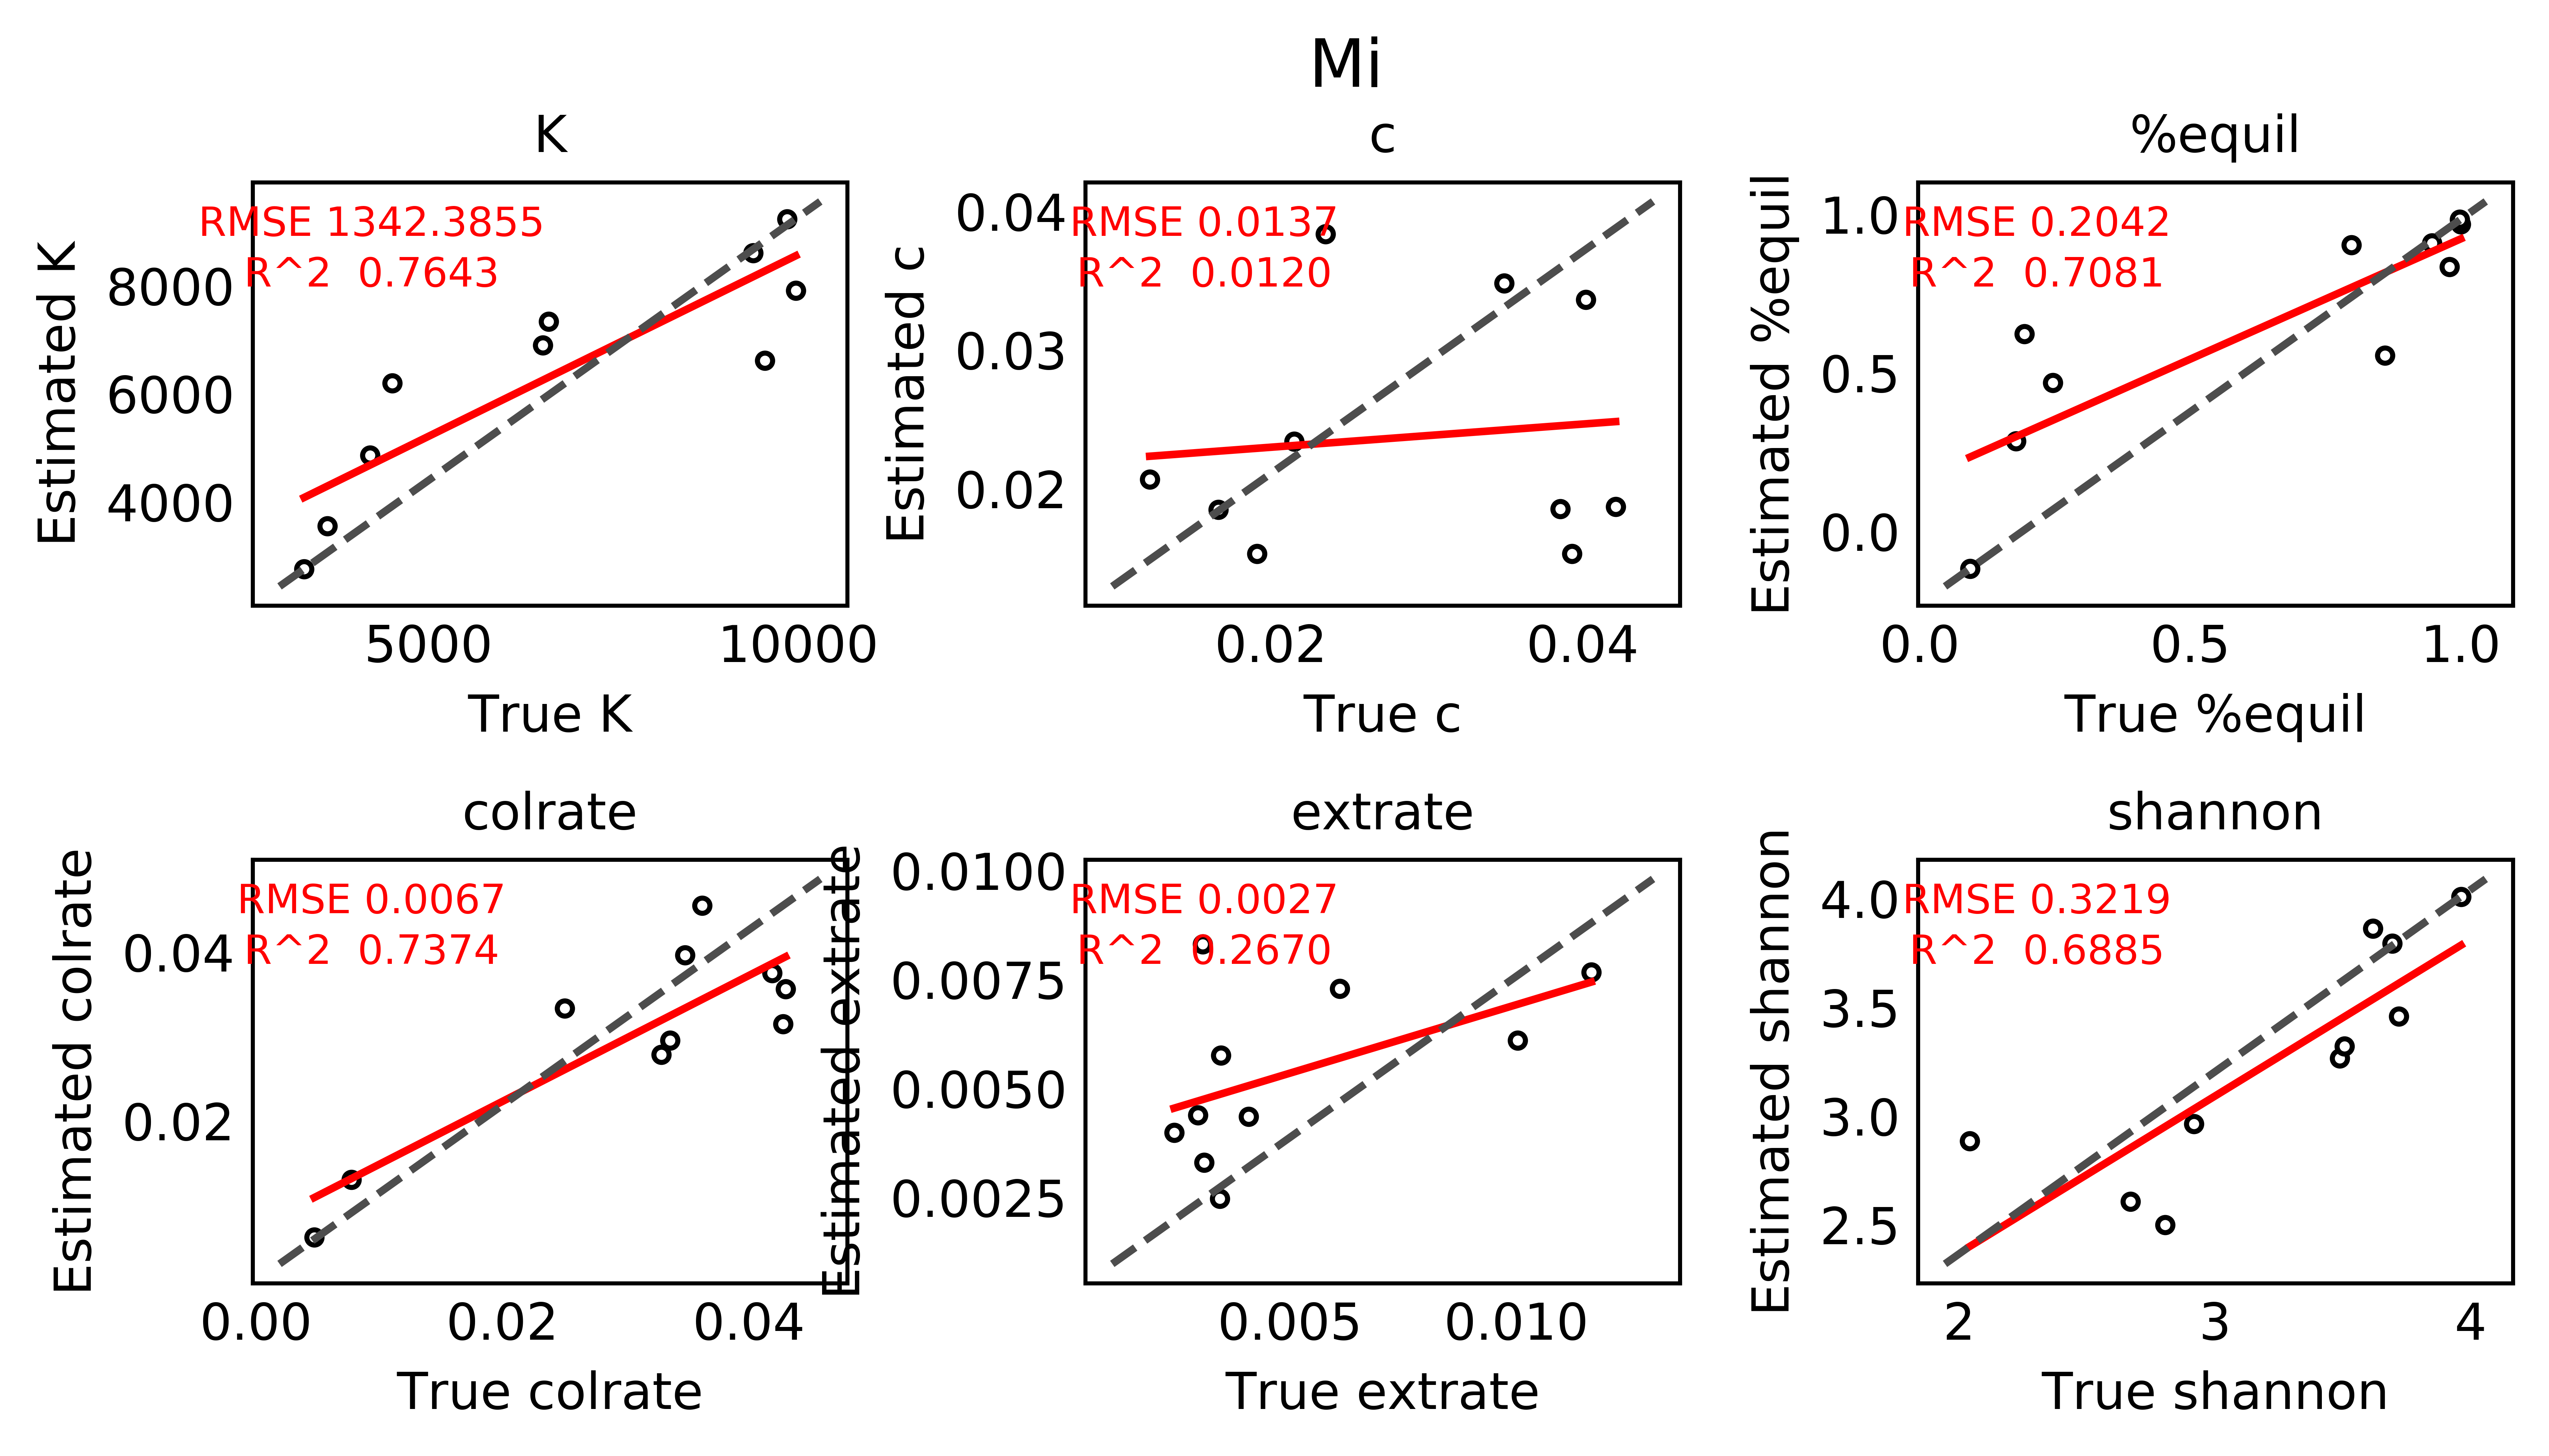

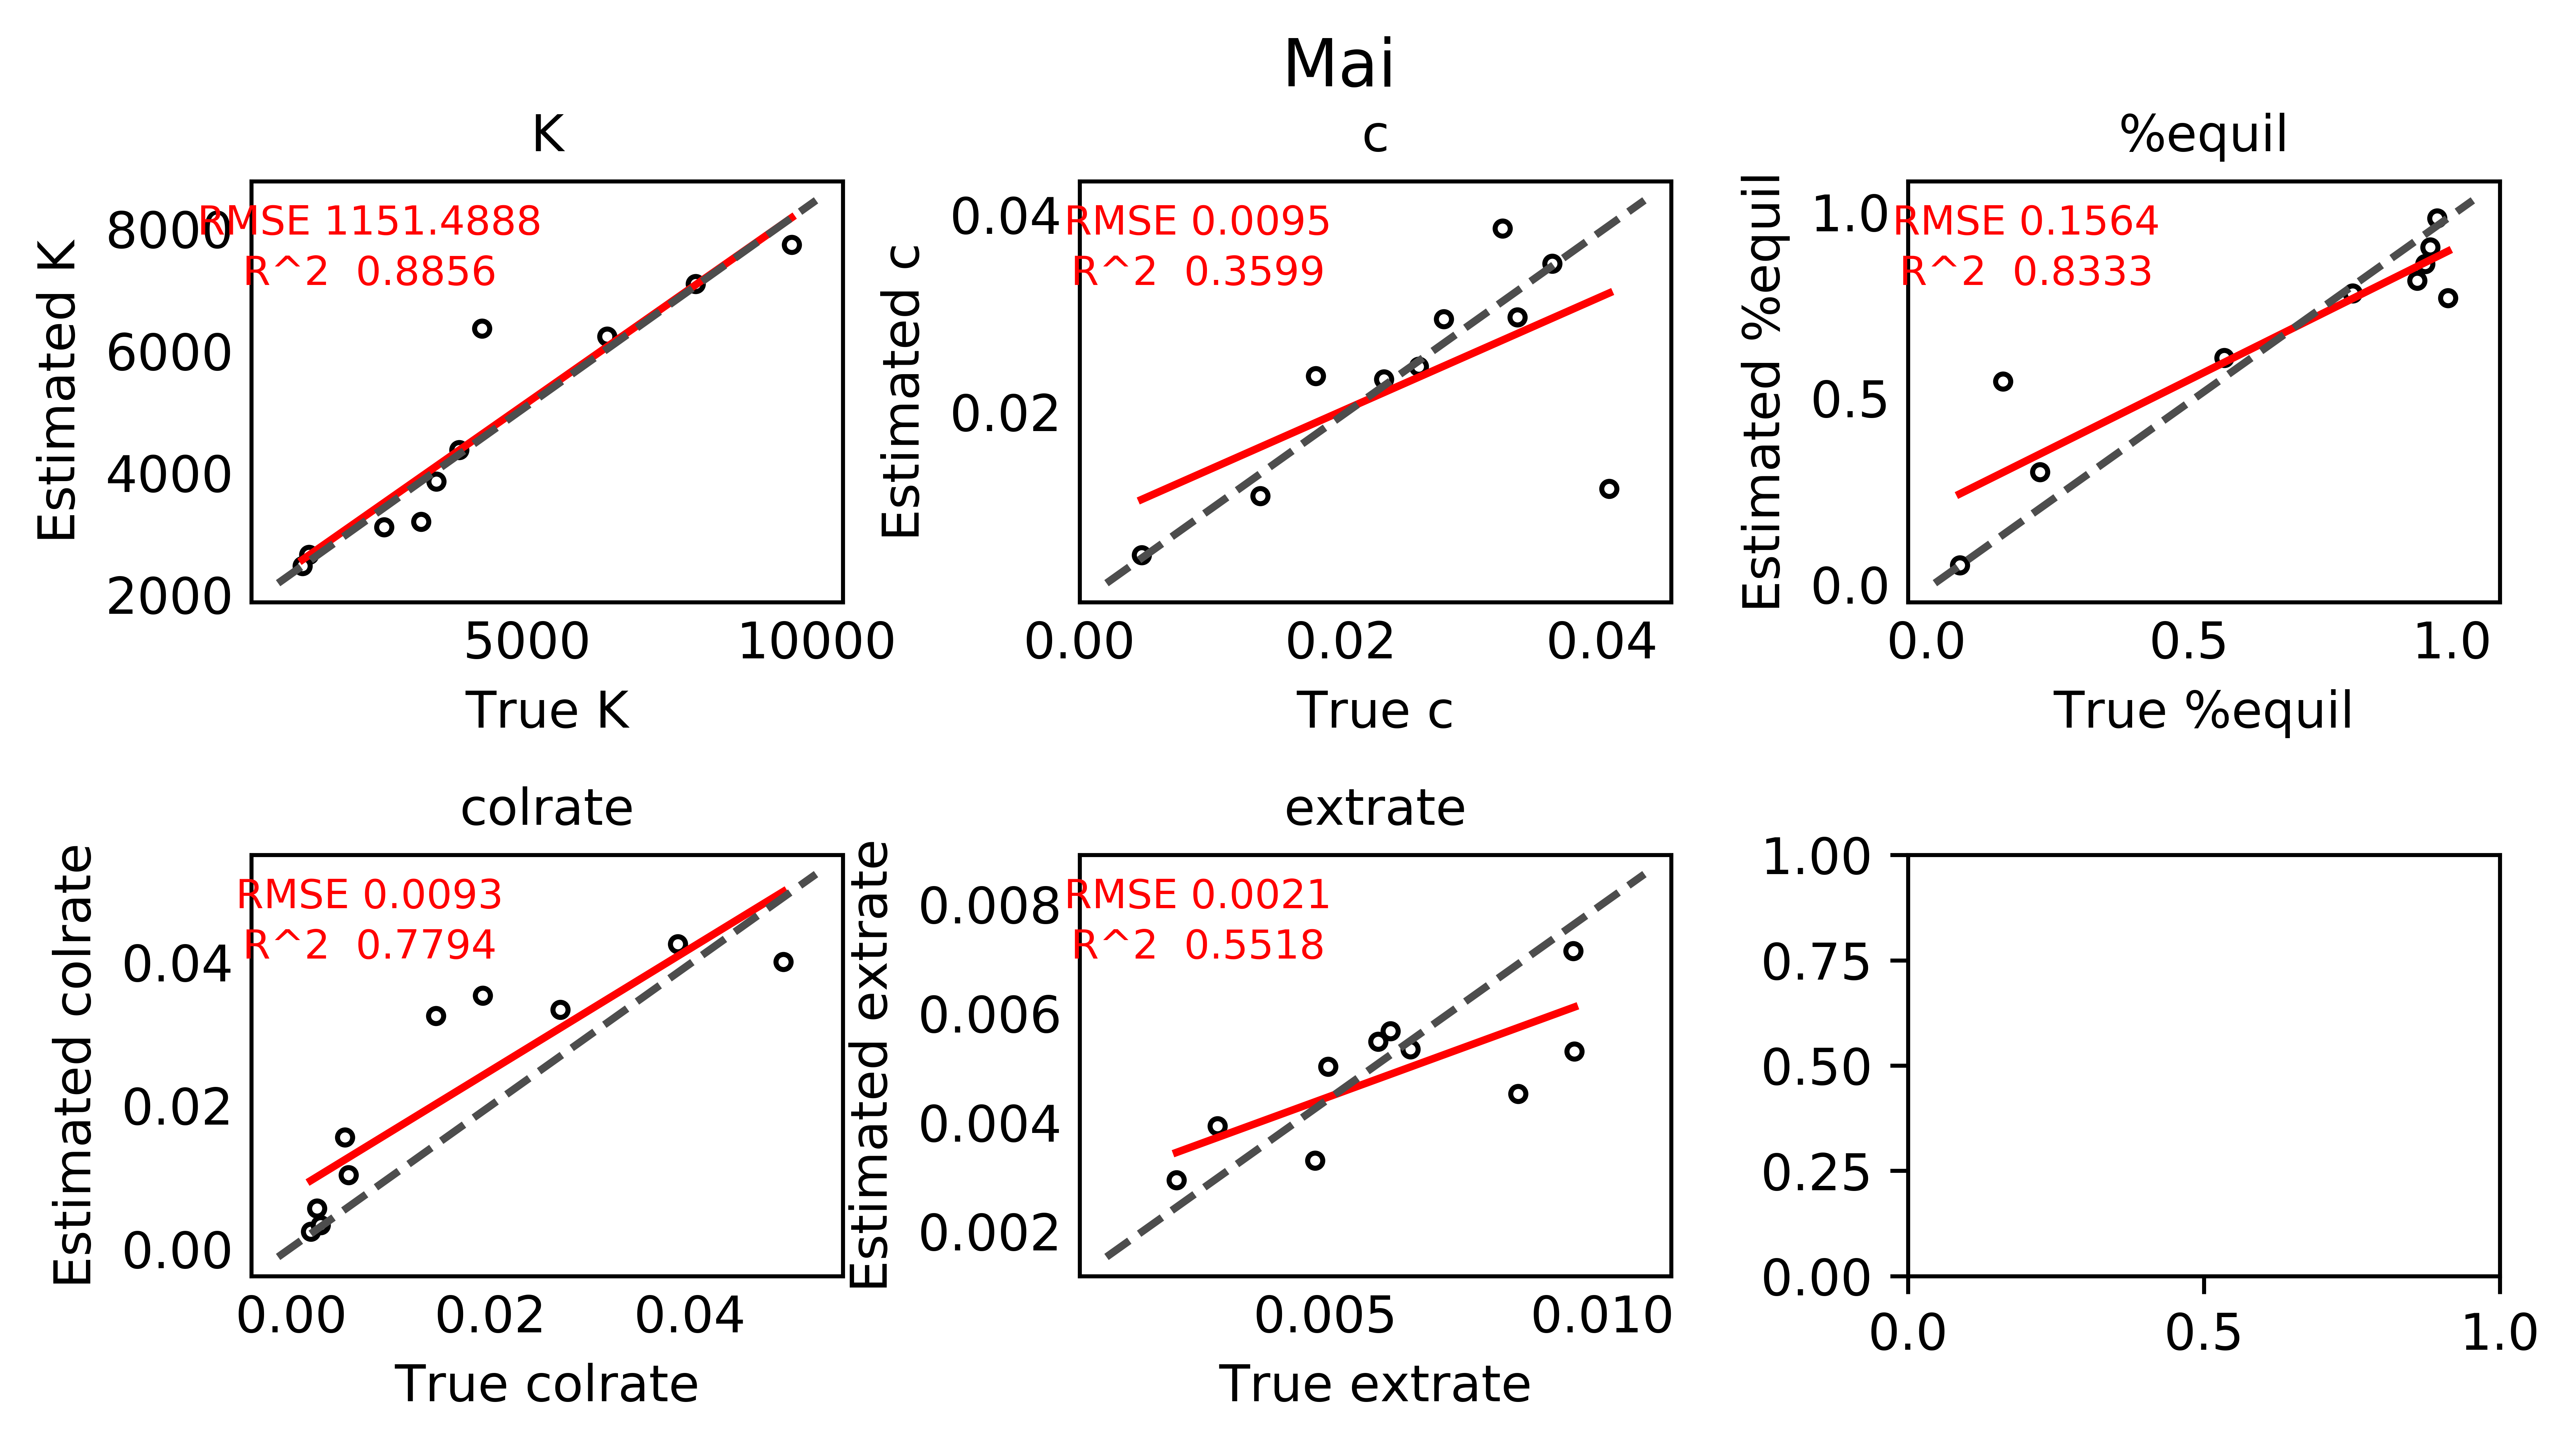

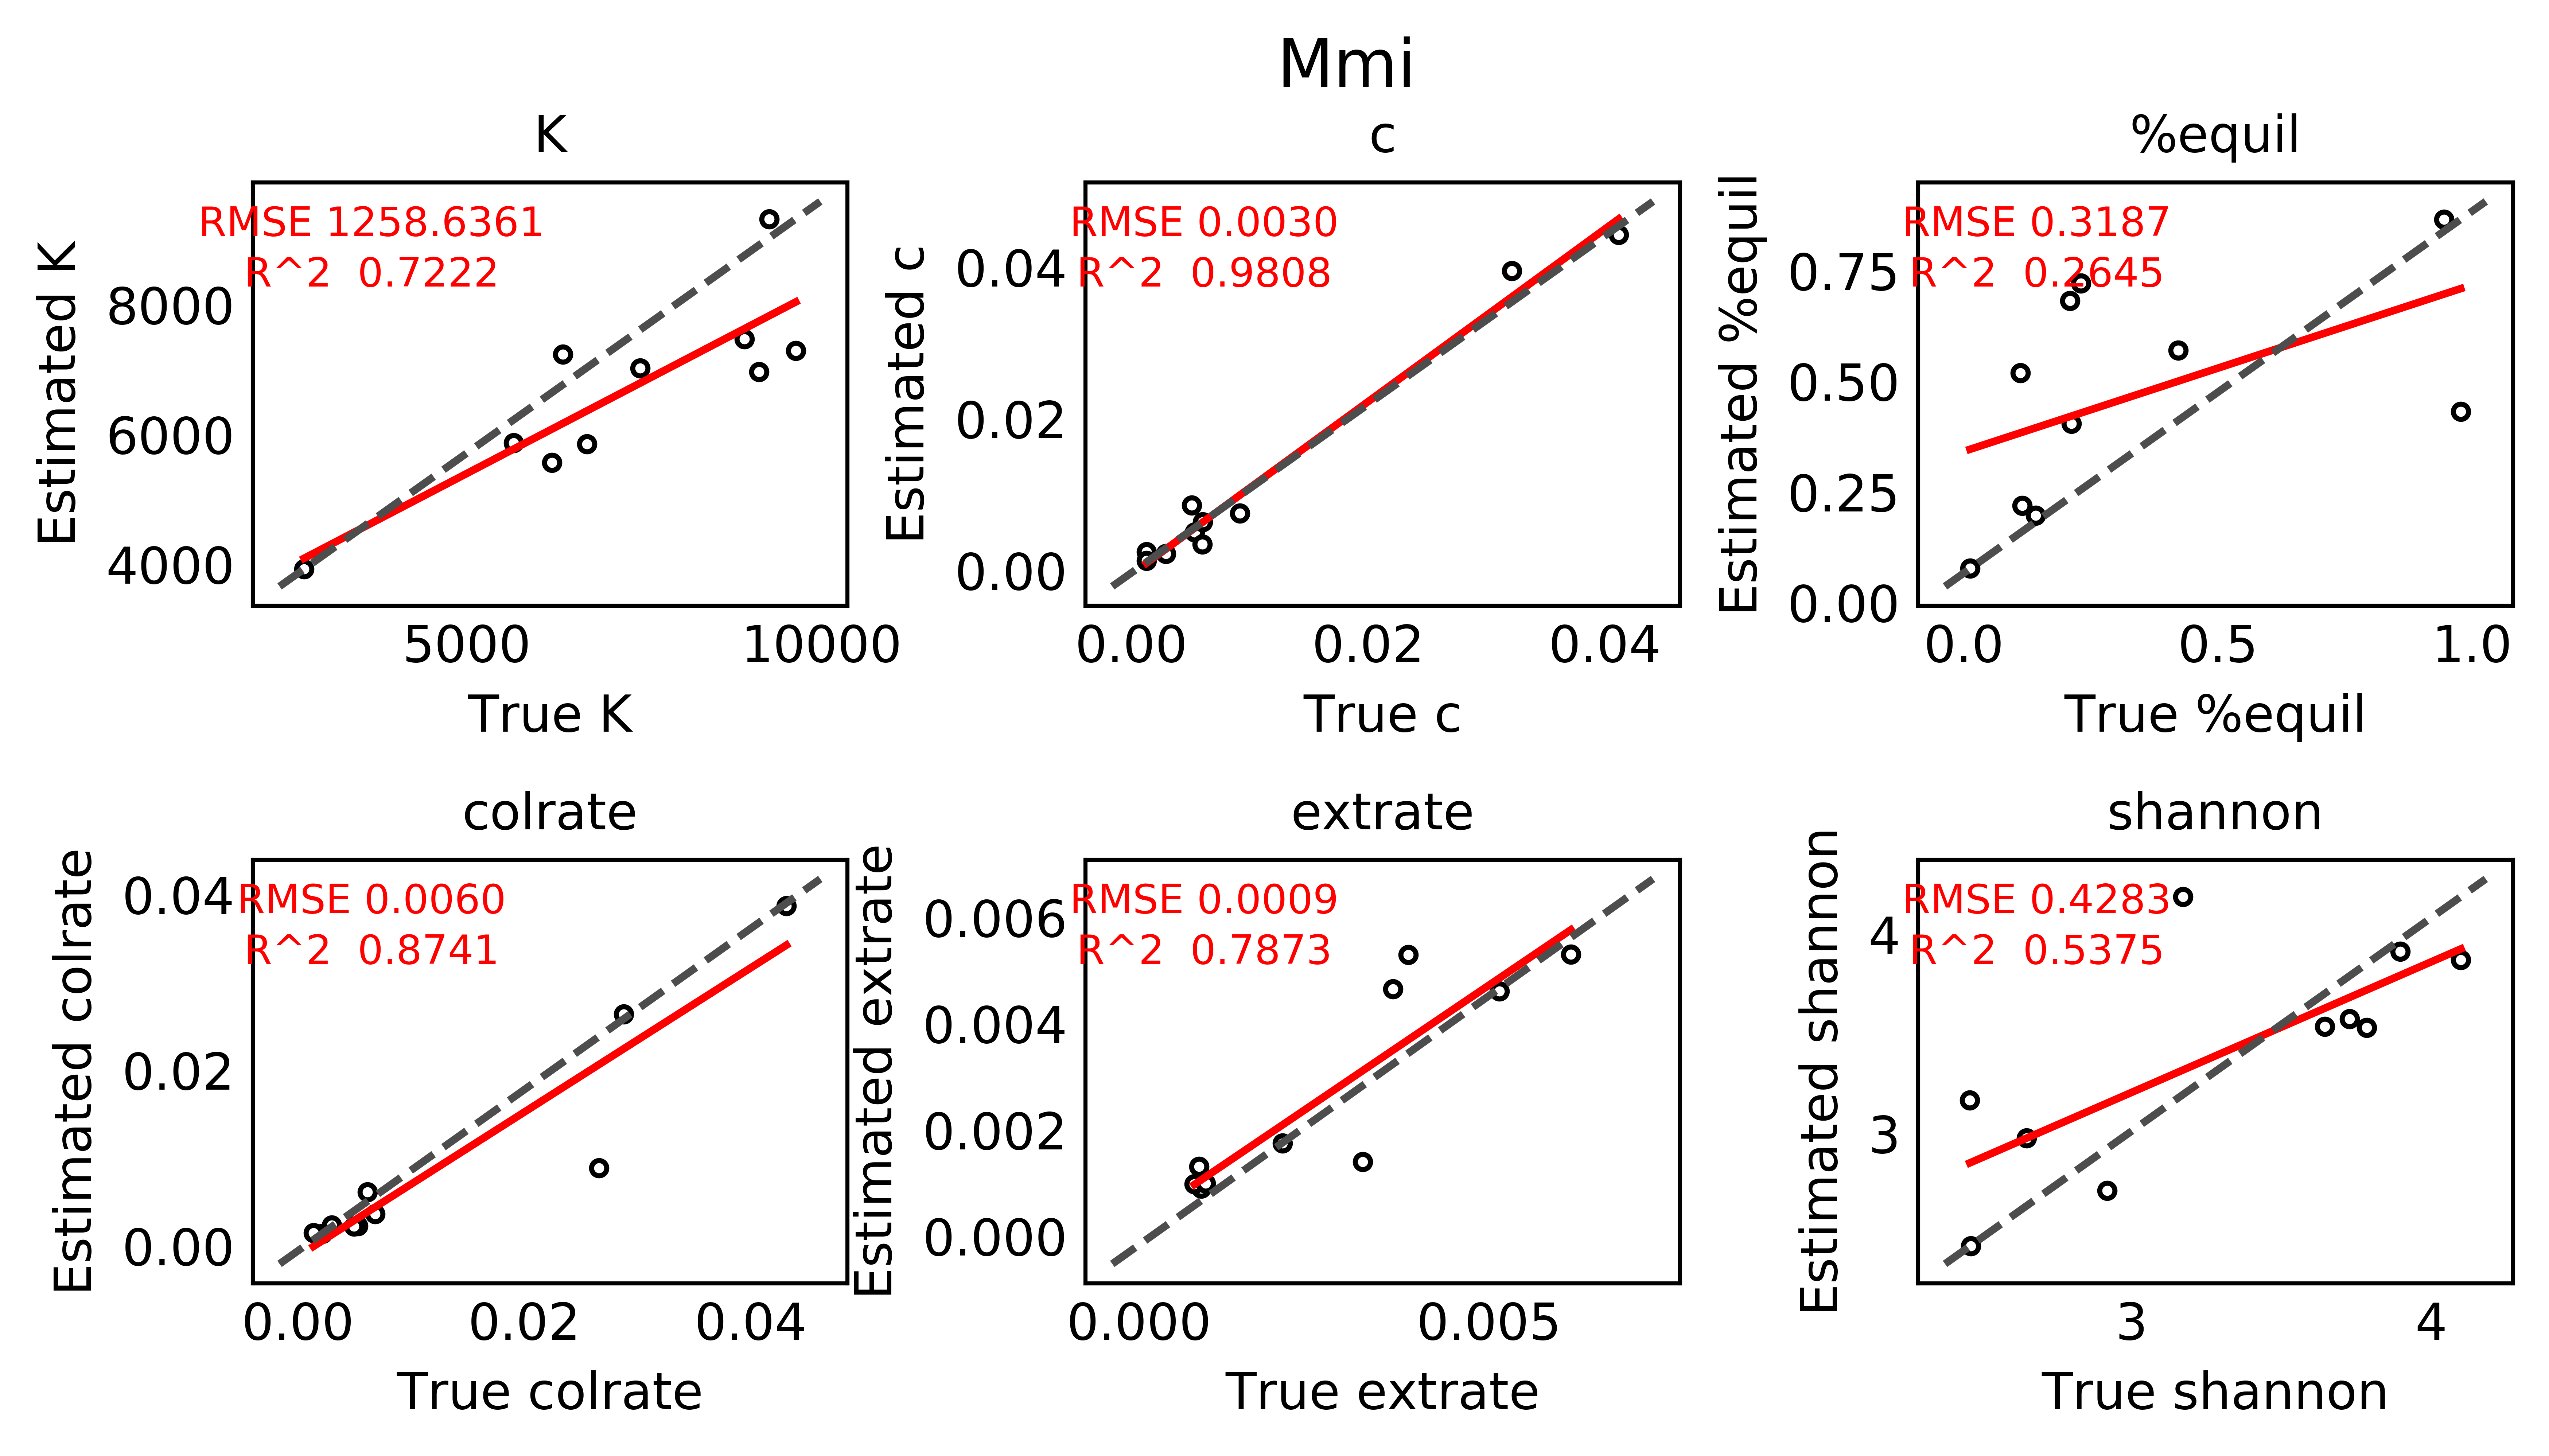

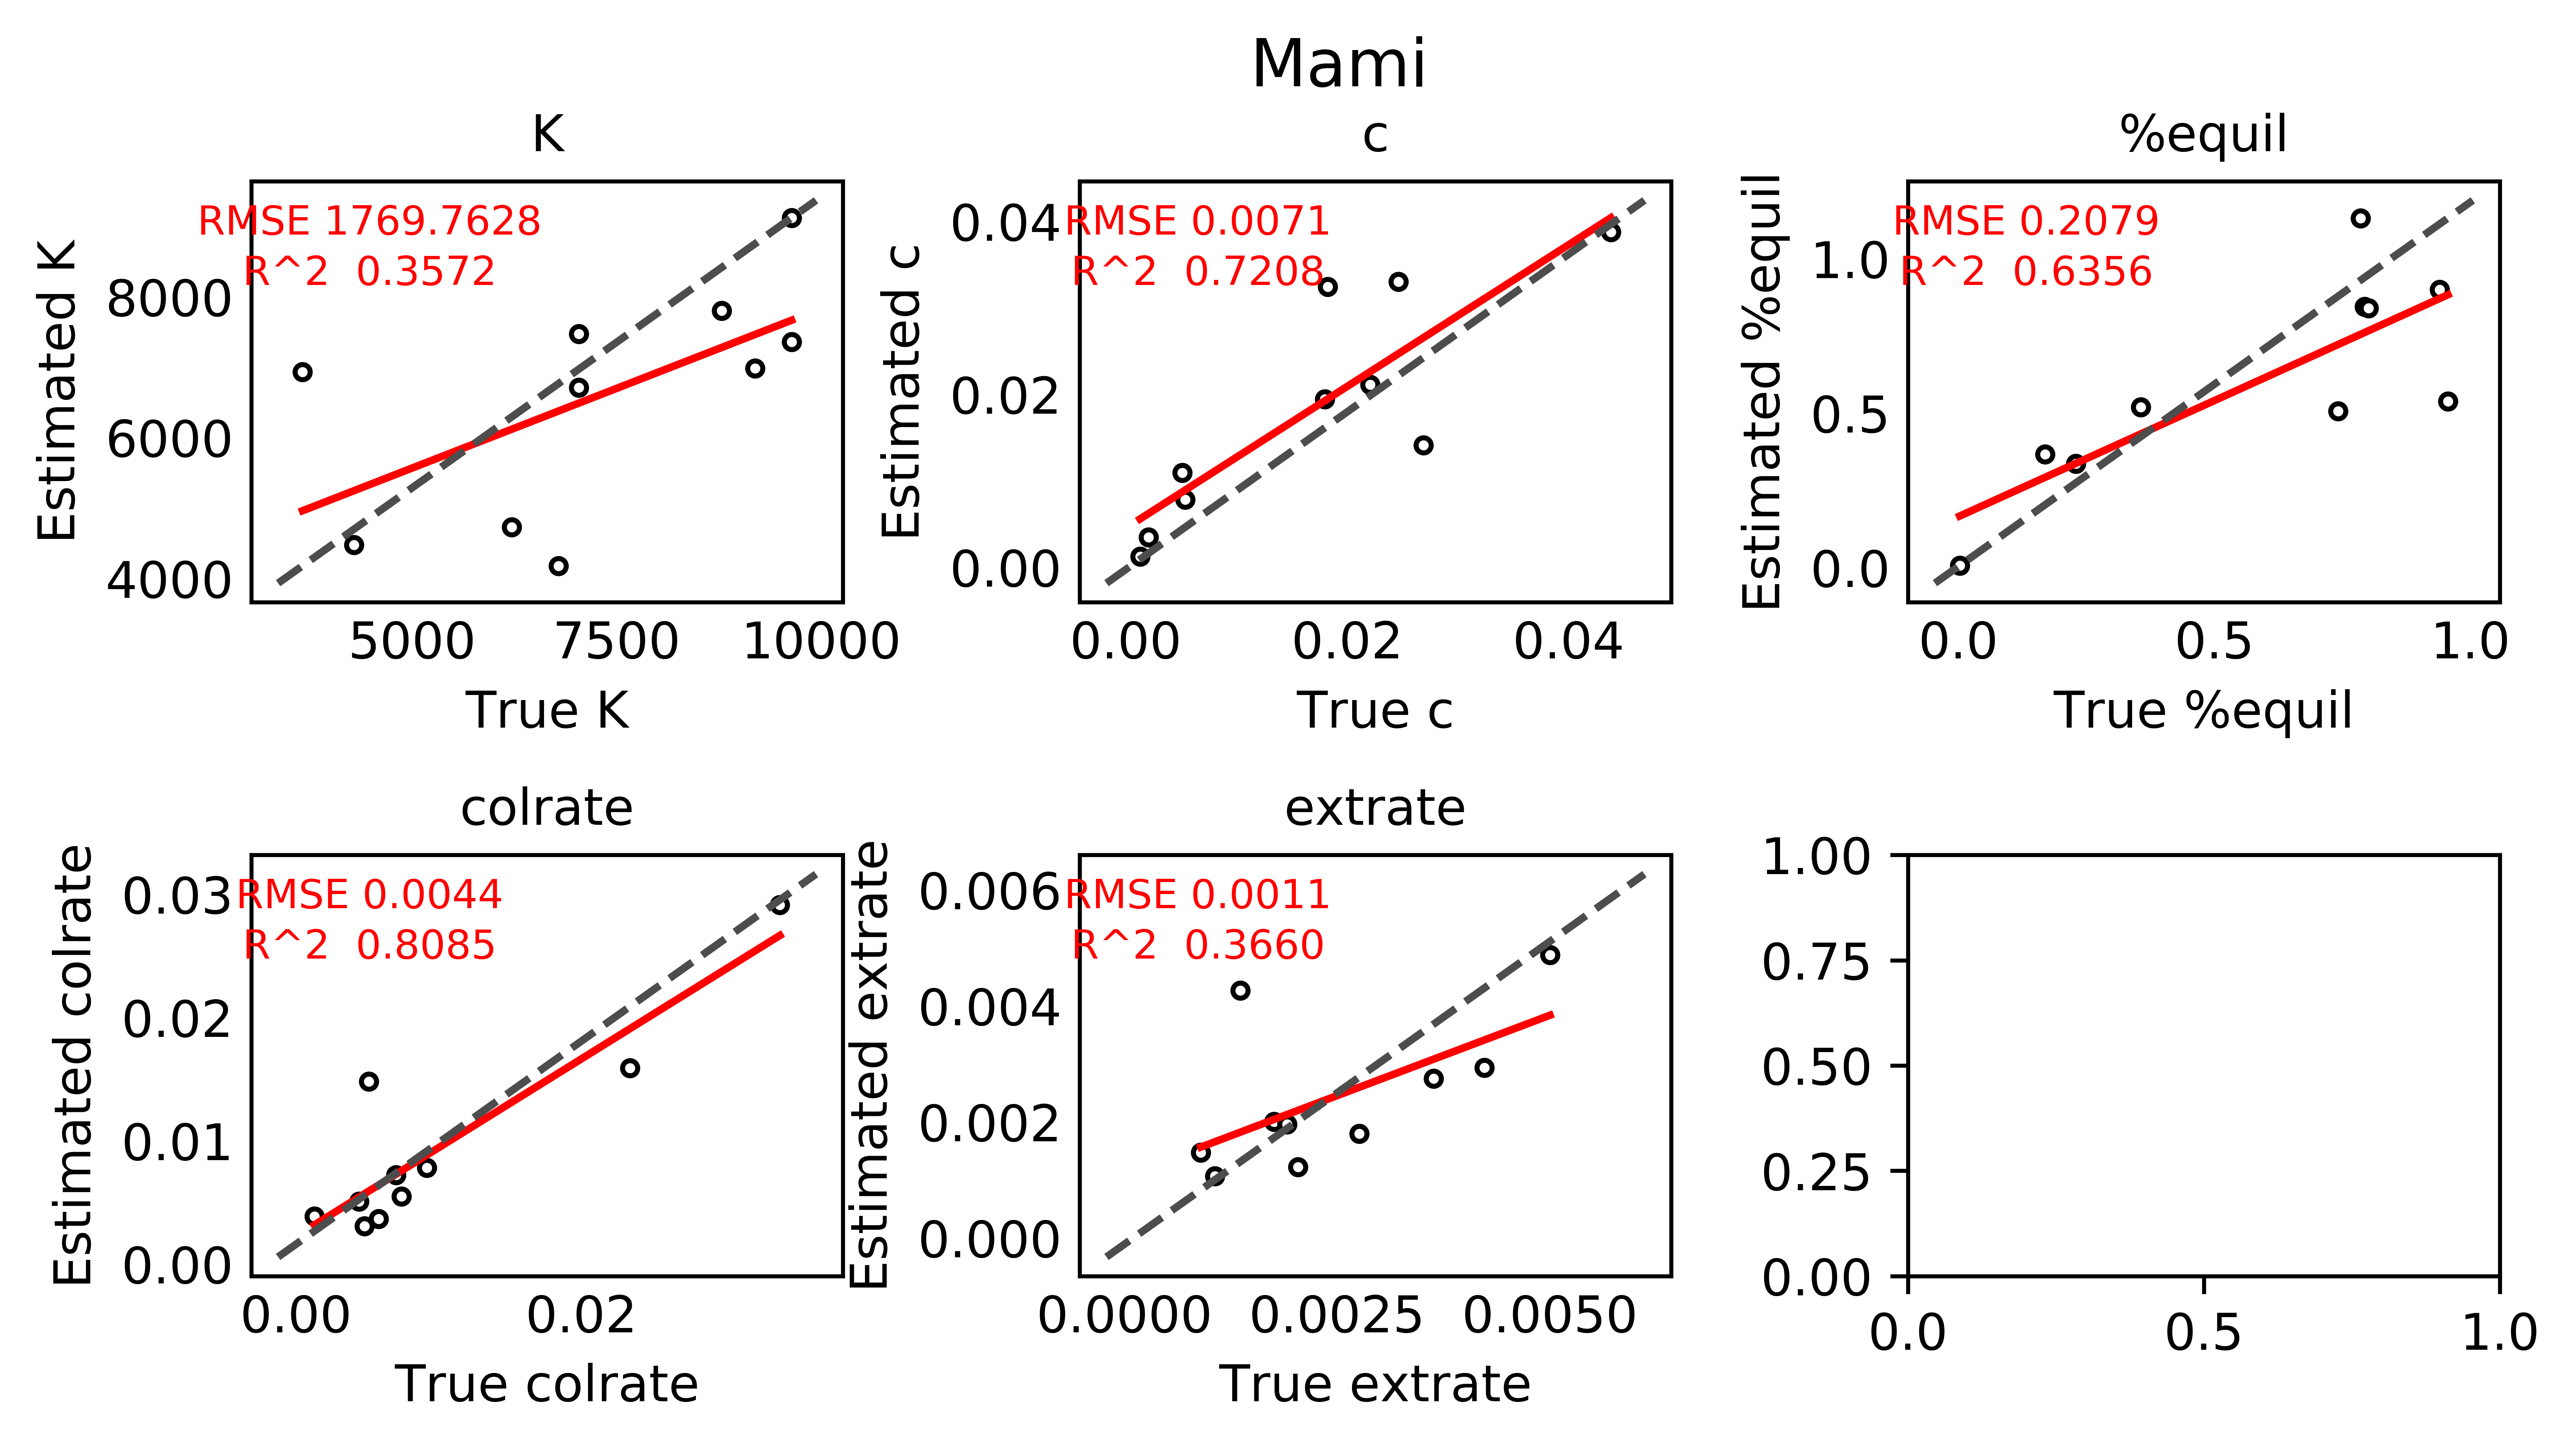

In [31]:
## Useful matplotlib style gallery
## https://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
## https://matplotlib.org/examples/style_sheets/style_sheets_reference.html
import matplotlib.style as style
for model in models: #["Mi"]:
    plot_cv(model, cv_dict)

## Everything below here is crap

In [78]:
type(results_dict["Mai"]["c"])

pandas.core.frame.DataFrame

# Scenario M(I) - 1D SGD
## Estimate H' using 1D π vector

## Estimate Λ using 1D π pi vector

# Scenario M(MI) - 2D SGD

# Scenario M(AMI) - 2D SGD & H'

Prediction errors for toy data
Doing Ma K
           P1
0.01 1.049726
0.05 1.026077

Doing Ma c
            P1
0.01 0.9894206
0.05 0.9391754

Doing Ma %equil
           P1
0.01 5.166433
0.05 4.635639

Doing Ma colrate
           P1
0.01 1.131167
0.05 1.112425

Doing Ma extrate
            P1
0.01 0.6154163
0.05 0.6359665

Skipping H' estimation for model - Ma
Doing Mi K
            P1
0.01 0.5387622
0.05 0.6091005

Doing Mi c
            P1
0.01 0.2045423
0.05 0.1664587

Doing Mi %equil
            P1
0.01 0.4951252
0.05 0.5074142

Doing Mi colrate
            P1
0.01 0.4026095
0.05 0.3773118

Doing Mi extrate
            P1
0.01 0.1989601
0.05 0.3307191

Doing Mi shannon
            P1
0.01 0.2072347
0.05 0.1879087

Doing Mai K
            P1
0.01 0.2776738
0.05 0.2095150

Doing Mai c
            P1
0.01 0.5255961
0.05 0.3998195

Doing Mai %equil
            P1
0.01 0.1260519
0.05 0.1117955

Doing Mai colrate
            P1
0.01 0.1765911
0.05 0.2231417

Doing Mai extrate
            P1
0.01 0.8608785
0.05 0.9572415

Skipping H' estimation for model - Mai
Doing Mmi K
            P1
0.01 1.2559241
0.05 0.5432039

Doing Mmi c
            P1
0.01 0.7936675
0.05 0.2866684

Doing Mmi %equil
            P1
0.01 0.3597958
0.05 0.3563132

Doing Mmi colrate
             P1
0.01 0.09534699
0.05 0.17672952

Doing Mmi extrate
           P1
0.01 15.78451
0.05  2.36977

Doing Mmi shannon
            P1
0.01 0.4453905
0.05 0.9180833

Doing Mami K
            P1
0.01 0.8146408
0.05 0.6199298

Doing Mami c
             P1
0.01 0.03459896
0.05 0.10983573

Doing Mami %equil
            P1
0.01 0.2210857
0.05 0.1317711

Doing Mami colrate
            P1
0.01 0.2577063
0.05 0.6711105

Doing Mami extrate
            P1
0.01 0.2276210
0.05 0.2185522

Skipping H' estimation for model - Mami

In [40]:
total = 0
for model in models:
    for param in params:
        results_dict[model][param] = thview.apply(call_abc, *[results_dict, model, param])
        total += 1
while 1:
    ready = [i.ready() for i in writers]
    elapsed = datetime.timedelta(seconds=int(time.time()-start))
    progressbar(total, sum(ready), printstr.format(elapsed))
    time.sleep(0.1)
    if all(ready):
        break

NameError: name 'call_abc' is not defined